In [1]:
fname = 'data/alex-2017-06-11_002_12d_tit2_D190uW_A80uW.hdf5'        

In [2]:
from pathlib import Path

In [3]:
fname = Path(fname)

In [4]:
mlabel_alex = '_'.join(fname.stem.replace('pax-', '').replace('alex-', '').split('_')[:3])
mlabel_alex

'2017-06-11_002_12d'

In [5]:
assert fname.is_file(), 'File not found.'

# Imports

In [6]:
import os
import numpy as np
from IPython.display import display, HTML
import pandas as pd
import matplotlib as mpl
mpl.rcParams['font.sans-serif'].insert(0, 'Arial')
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import lmfit; lmfit.__version__

'0.9.6'

In [8]:
import phconvert; phconvert.__version__

'0.7.3+59.ge1df860'

In [9]:
%config InlineBackend.figure_format = 'retina'

In [10]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.6.5).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [11]:
sns = init_notebook(apionly=True)

In [12]:
# load utility function (not import) giving them access to globals ("-i" flag)
# Defines: savefig, save_name, info_html, cal_phrate, make_df_spots, make_df_bursts
#          cal_phrate_alex, make_df_bursts_alex
%run -i utils.py  

In [13]:
save_figures = True
savefigdir = 'figures'
highres = True

# Load the selected file

We can finally load the data and store it in a variable called `d`:

In [14]:
d = loader.photon_hdf5(fname)

In [15]:
info_html(d)

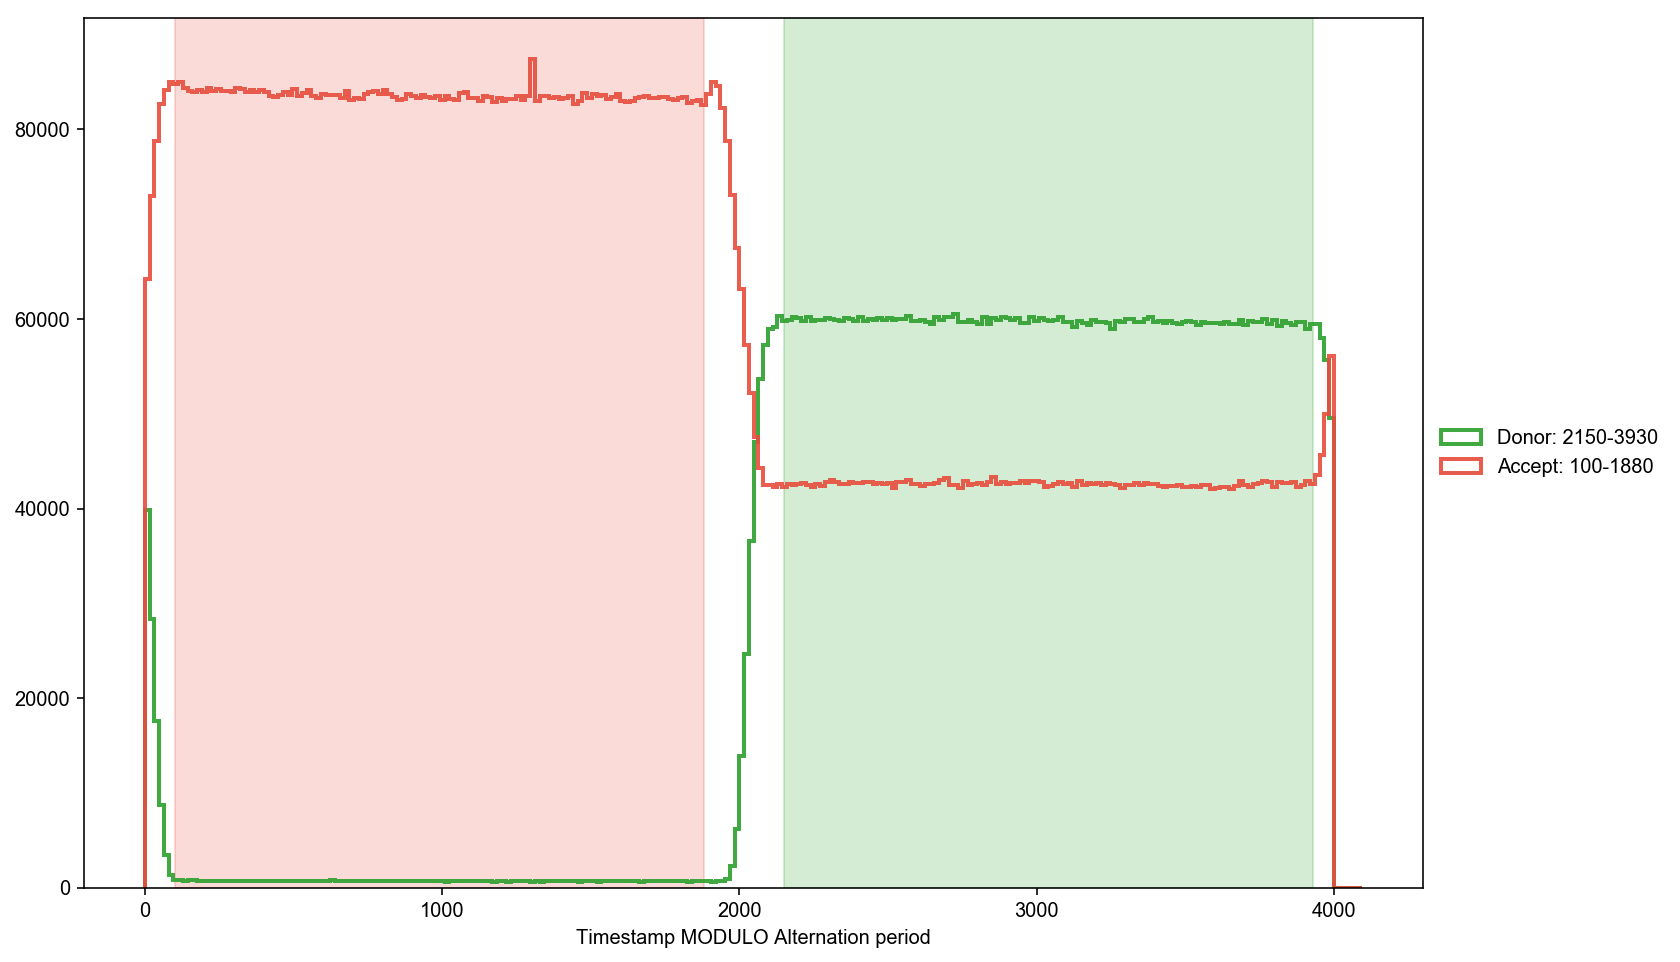

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
bpl.plot_alternation_hist_usalex(d, ax=ax, bins=np.arange(0, 4097, 16))

If the previous alternation histogram looks correct, 
the corresponding definitions of the excitation periods can be applied to the data using the following command:

In [17]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):    20,767,423
#  D  photons in D+A excitation periods:    6,729,304
#  A  photons in D+A excitation periods:   14,038,119
# D+A photons in  D  excitation period:    11,390,341
# D+A photons in  A  excitation period:     9,377,082



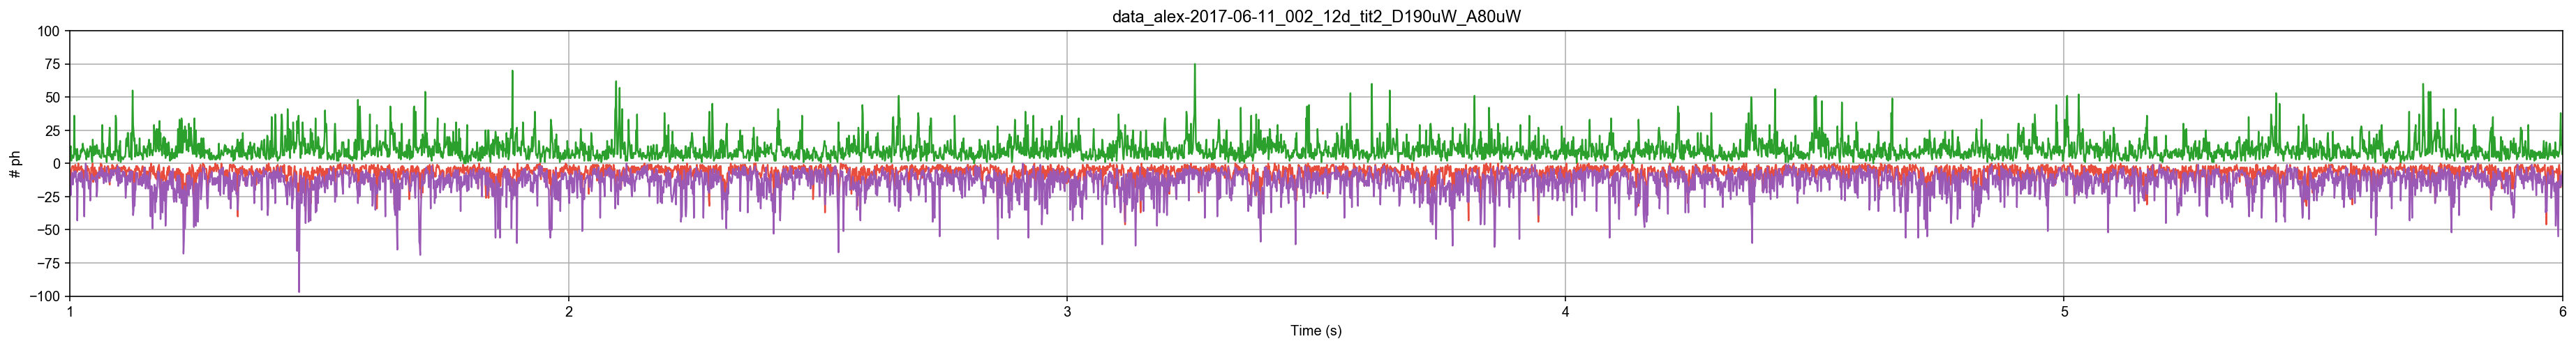

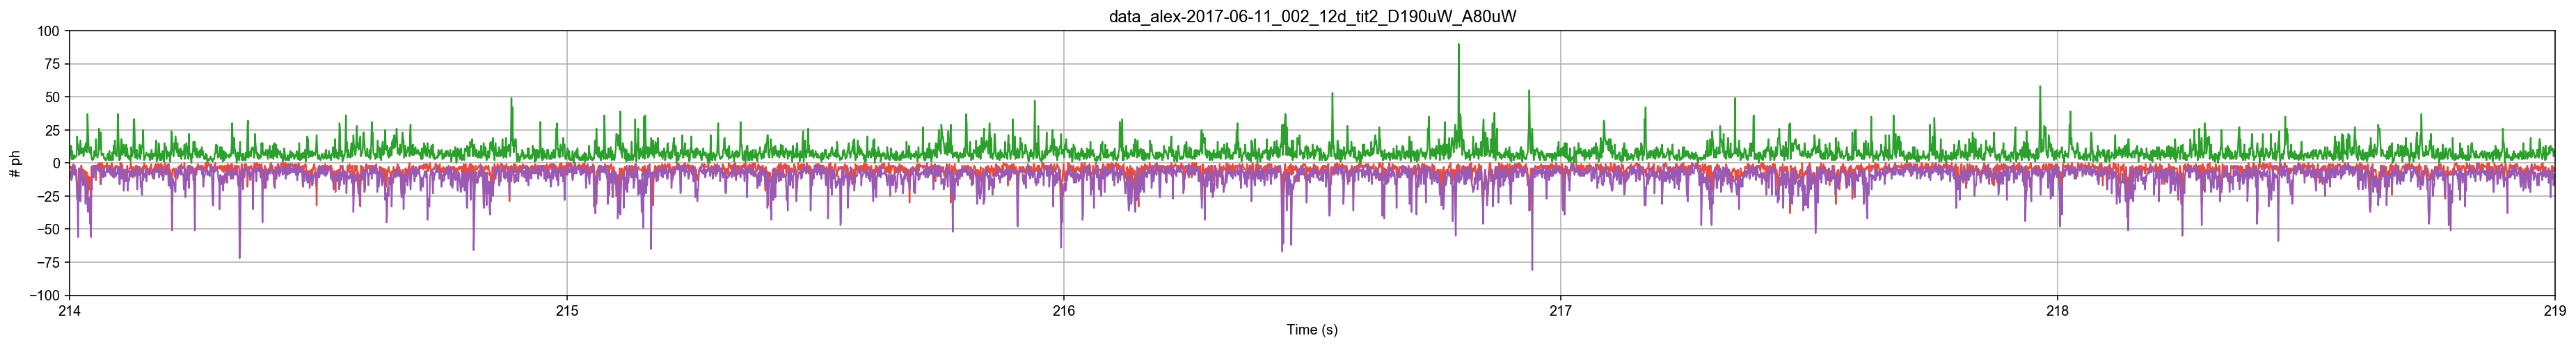

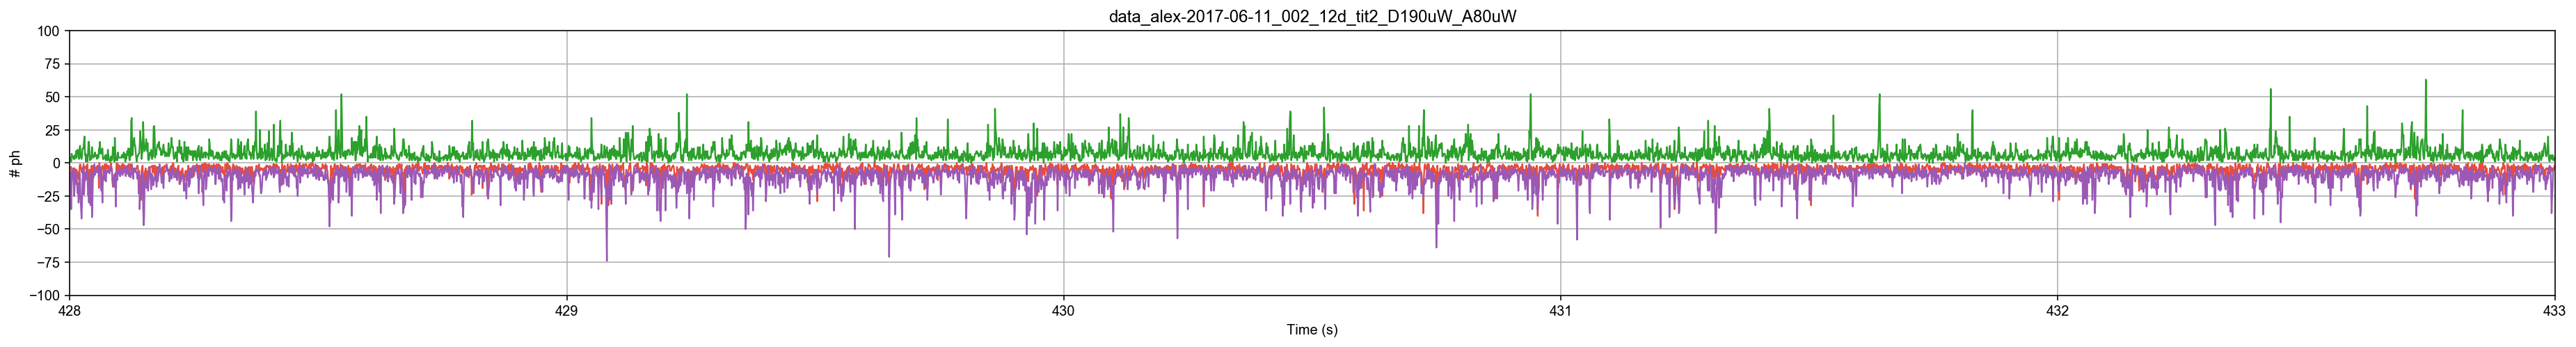

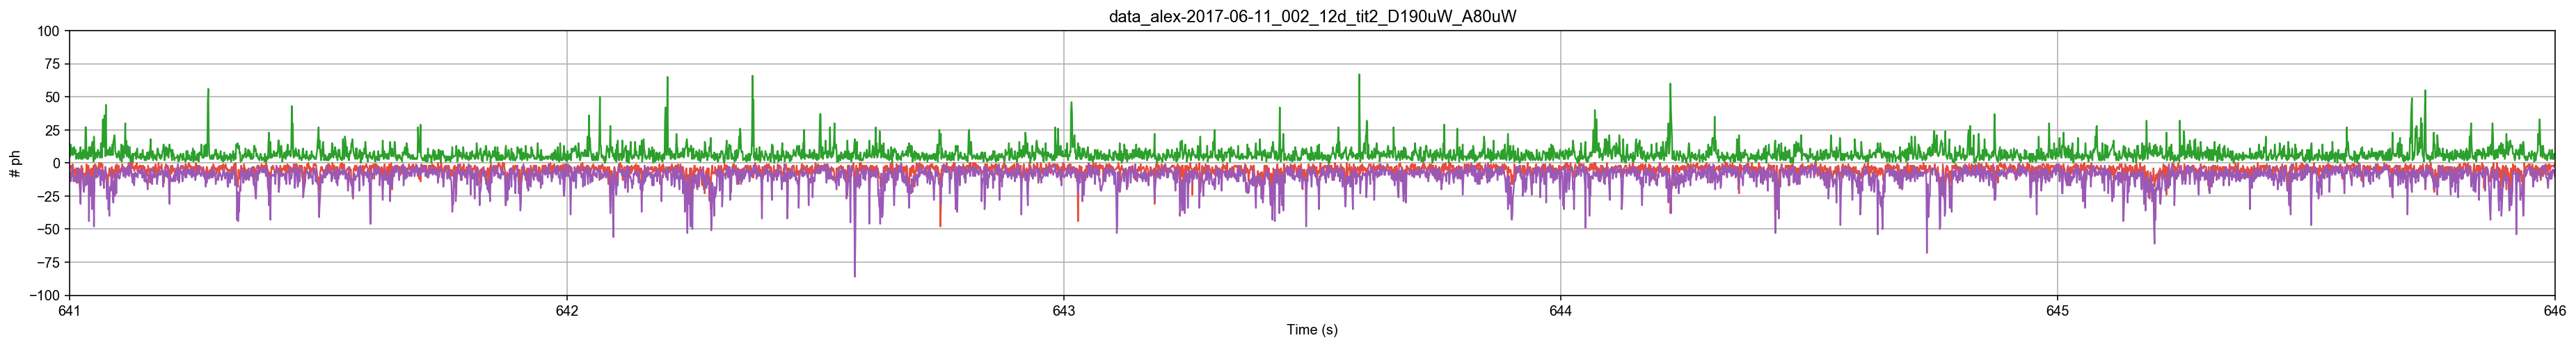

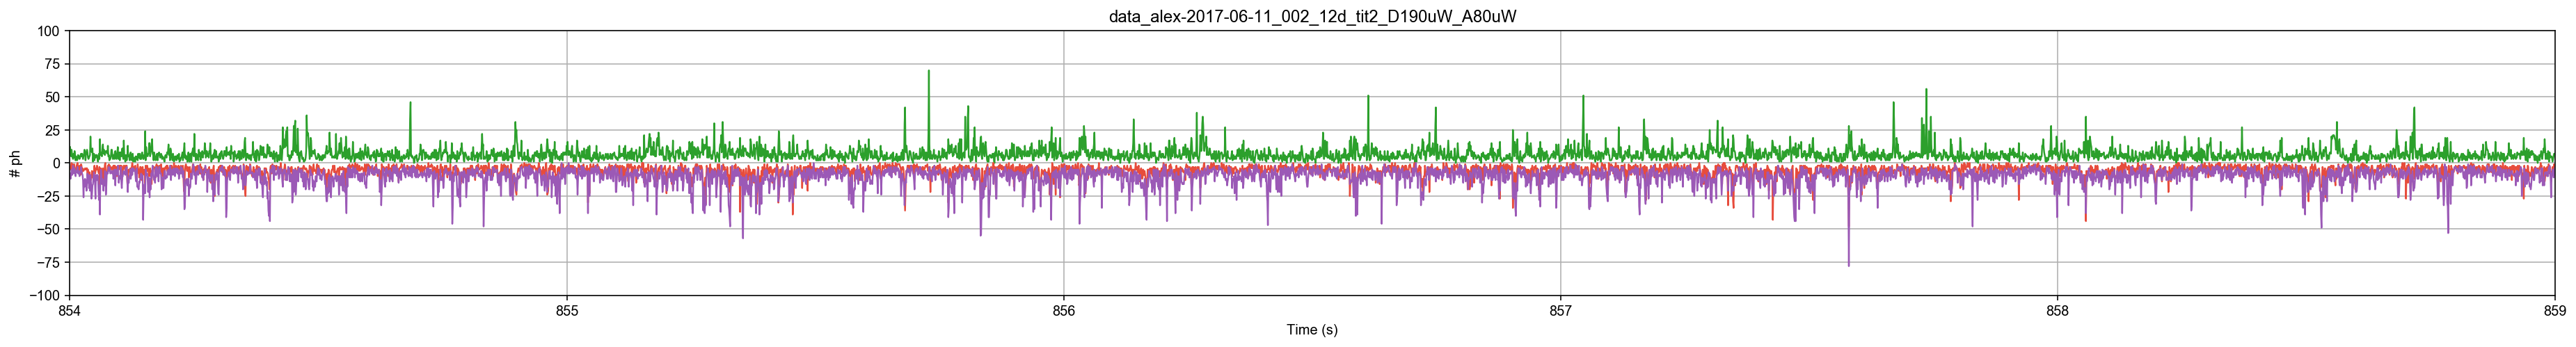

In [18]:
num_time_points = 5
window = 5

# Timepoints equally distributed along the measurement
time_points = np.round(np.linspace(d.time_min+1, d.time_max-window-1, num=num_time_points))

for i in time_points:
    dplot(d, timetrace, tmin=i, tmax=i+window, figsize=(32, 3.5));
    plt.ylim(-100, 100)
    plt.xlim(i, i+window)

In [19]:
d.calc_bg(bg.exp_fit, time_s=10, tail_min_us='auto', F_bg=1)

 - Calculating BG rates ... [DONE]


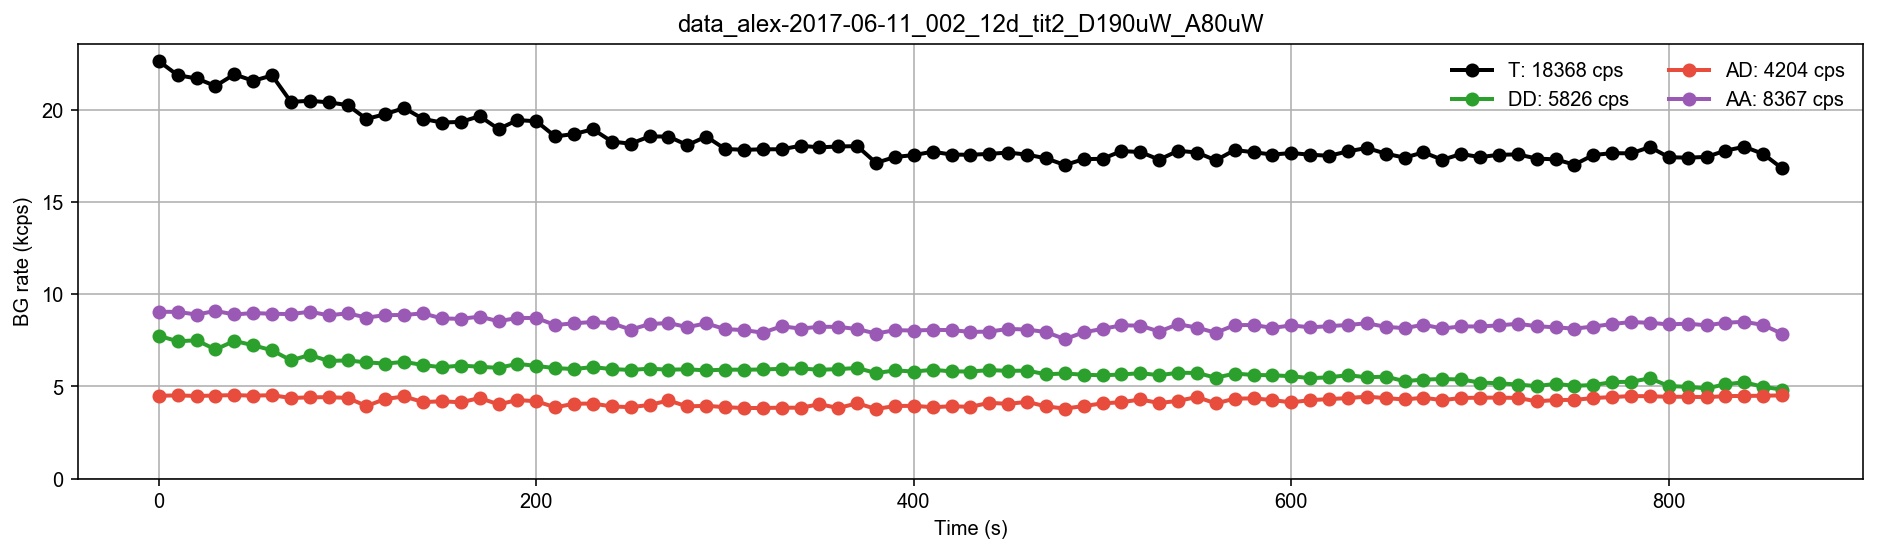

In [20]:
fig, ax = plt.subplots(figsize=(16, 4))
dplot(d, timetrace_bg, ax=ax)

# Burst analysis

In [21]:
d.burst_search(min_rate_cps=50e3)
d = d.select_bursts(select_bursts.time, time_s1=200)
d.num_bursts

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


array([342499])

(-27.600000000000001, 500)

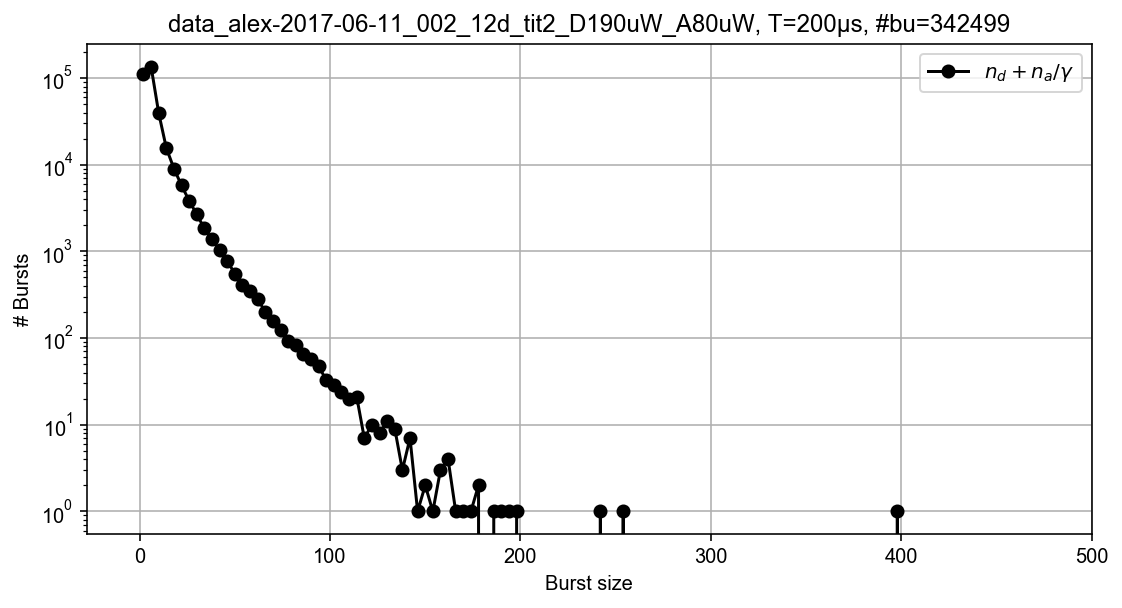

In [22]:
dplot(d, hist_size)
plt.xlim(None, 500)

(0, 10)

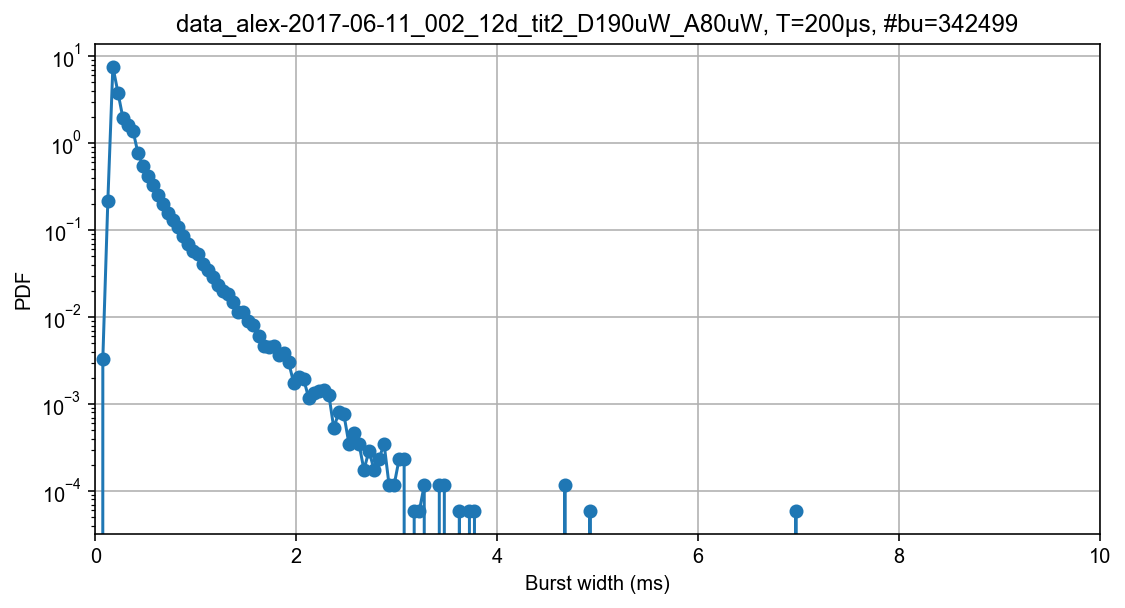

In [23]:
dplot(d, hist_width, bins=(0, 10, 0.05))
plt.xlim(0, 10)

In [24]:
d.calc_max_rate(m=10, ph_sel=Ph_sel(Dex='Dem'), compact=True)

In [25]:
recompute = True
streams = ('DexDem', 'DexAem', 'AexAem')
colors = (bpl.green, bpl.red, bpl.purple)
phrates = {}
for stream in streams:
    print(' - Computing peak photon rates for %6s stream.' % str(Ph_sel.from_str(stream)))
    cal_phrate_alex(d, stream=Ph_sel.from_str(stream), phrates=phrates, recompute=recompute)

 - Computing peak photon rates for DexDem stream.
   Valid fraction (mean of all ch): 13.4 %
 - Computing peak photon rates for DexAem stream.
   Valid fraction (mean of all ch): 8.9 %
 - Computing peak photon rates for AexAem stream.
   Valid fraction (mean of all ch): 23.3 %


In [26]:
phrates[stream]

{'num_bursts': 342499,
 'num_nans': 262693,
 'num_valid': 79806,
 'valid_fraction': 23.301089930189576}

In [27]:
phr_dd = phrates['DexDemB']
phr_dd[0]

0                  NaN
1                  NaN
2                  NaN
3                  NaN
4         52885.869759
5                  NaN
6         32292.659995
7                  NaN
8                  NaN
9                  NaN
10                 NaN
11                 NaN
12                 NaN
13                 NaN
14                 NaN
15                 NaN
16                 NaN
17        77768.242940
18                 NaN
19                 NaN
20                 NaN
21                 NaN
22                 NaN
23                 NaN
              ...     
342475             NaN
342476             NaN
342477             NaN
342478             NaN
342479             NaN
342480             NaN
342481             NaN
342482             NaN
342483             NaN
342484             NaN
342485             NaN
342486             NaN
342487             NaN
342488             NaN
342489             NaN
342490             NaN
342491             NaN
342492             NaN
342493     

In [28]:
float(phr_dd.loc[phr_dd[0]>100e3].mean() - 100e3)

85389.3285106869

Saved: figures/2017-06-11_002_12d_usALEX_peak_phrate.png
Saved hires: figures/2017-06-11_002_12d_usALEX_peak_phrate_highres.png


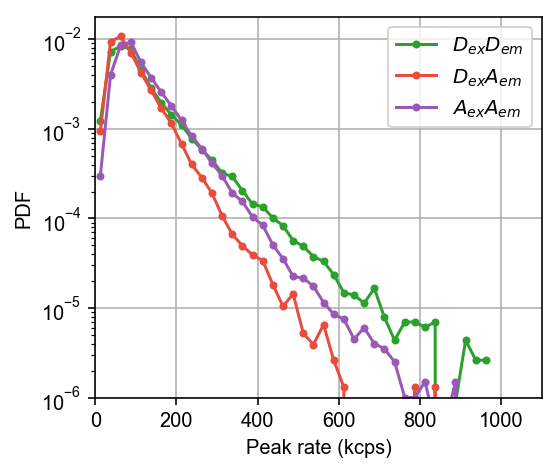

In [29]:
fig, ax = plt.subplots(figsize=(4, 3.5))
bins = (0, 1000, 25)
for stream, color in zip(streams, colors):
    hist_burst_phrate(phrates[stream+'B'], bins=bins, plot_style=dict(color=color, ms=3, label=stream))
plt.xlim(0, 1100)
plt.ylim(1e-6)
plt.title(d.name)
plt.legend(['$D_{ex}D_{em}$', '$D_{ex}A_{em}$', '$A_{ex}A_{em}$'])
plt.grid()
plt.title('')
savefig('usALEX_peak_phrate', label=mlabel_alex)

In [30]:
d.burst_sizes_ich()

array([ 2.83606608,  3.86595254,  2.88527568, ...,  2.04204755,
        4.95810695,  1.16206276])

In [31]:
ds = d.select_bursts(select_bursts.size, th1=40, gamma=1)

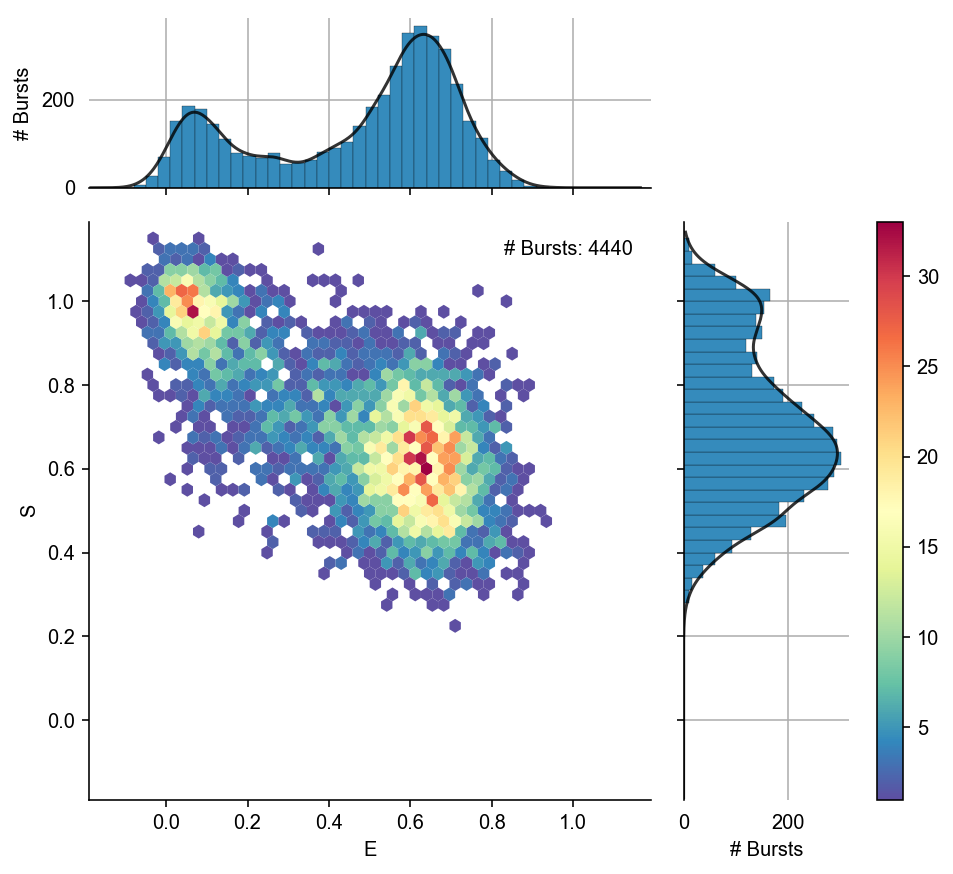

In [32]:
alex_jointplot(ds, vmax_fret=False, vmin=1)

In [33]:
ds1 = d.select_bursts(select_bursts.naa, th1=20)
dss = ds1.select_bursts(select_bursts.size, th1=40)

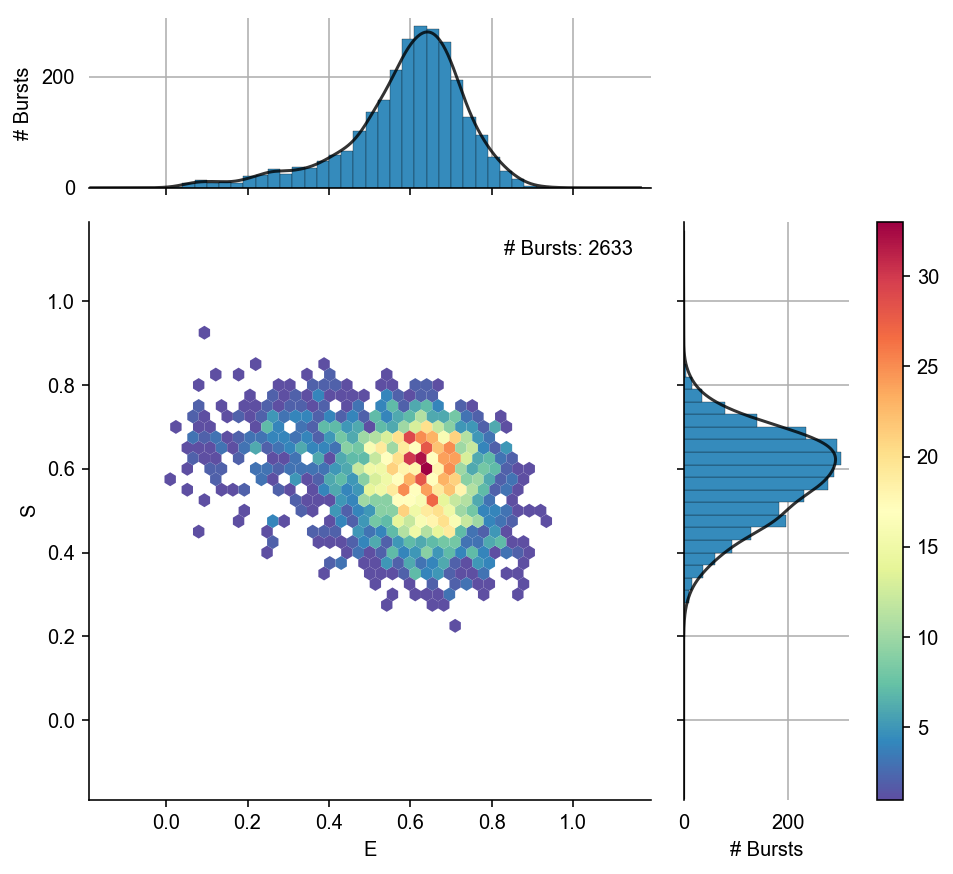

In [34]:
alex_jointplot(dss, vmax_fret=False, vmin=1)

In [35]:
d2 = bext.burst_search_and_gate(d, min_rate_cps=30e3)

Deep copy executed.
Deep copy executed.
Deep copy executed.
 - Performing burst search (verbose=False) ... - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Performing burst search (verbose=False) ... - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


In [36]:
ds2 = d2.select_bursts(select_bursts.size, th1=30)

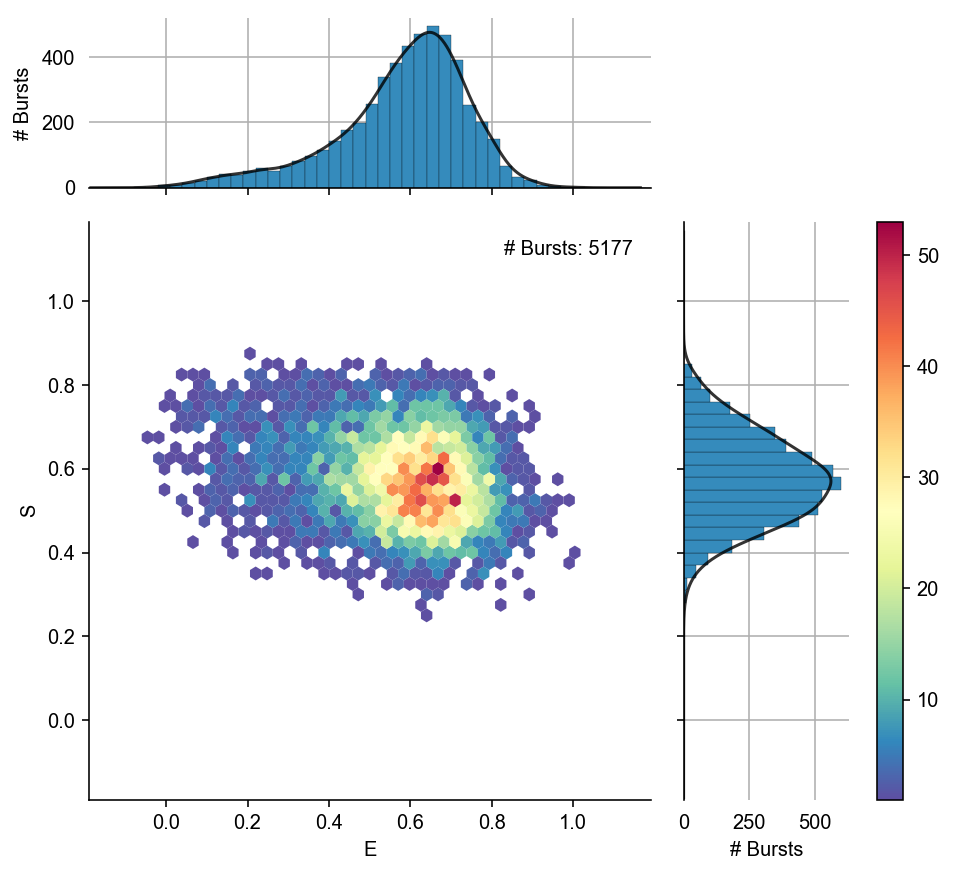

In [37]:
alex_jointplot(ds2, vmax_fret=False, vmin=1)

In [38]:
vals, counts = np.unique(ds.burst_data_ich(0)['bg_period'], return_counts=True)

In [39]:
counts

array([106, 107,  89, 106,  83,  80,  94,  91,  96,  80,  71,  68,  79,
        62,  80,  71,  74,  77,  54,  66,  68,  72,  52,  59,  62,  53,
        61,  61,  58,  59,  67,  51,  53,  62,  67,  66,  49,  58,  55,
        68,  53,  49,  64,  67,  54,  64,  58,  48,  66,  58,  63,  59,
        74,  50,  73,  54,  56,  63,  51,  80,  61,  81,  75,  62,  62,
        59,   1])

(0, 112.3)

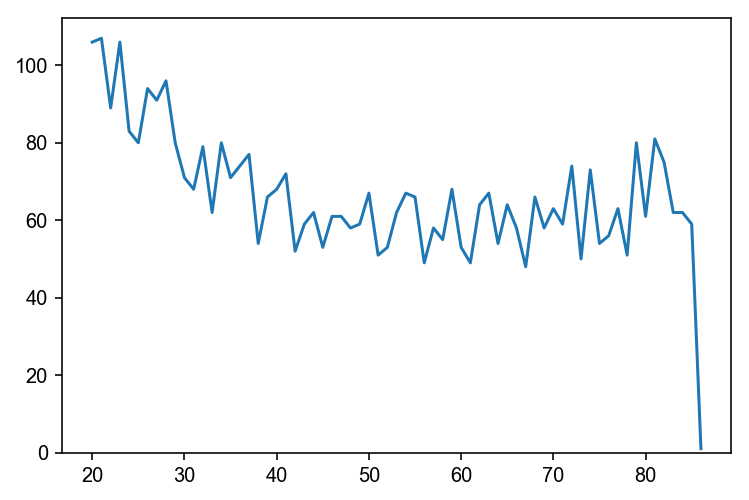

In [40]:
plt.plot(vals, counts)
plt.ylim(0)